In [2]:
%pylab inline
import numpy as np
import scipy
import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def load_npz_to_csr(npz_fname):
    npz = np.load(npz_fname)
    csr = scipy.sparse.csr_matrix(
        (npz['data'], npz['indices'], npz['indptr']),
        shape=npz['shape'])
    return csr.astype('f')

# load the global and local connectivity matrices
G = load_npz_to_csr('vert2vert_gdist_mat_32k.npz')
L = load_npz_to_csr('vert2vert_lengths_32k_15M.npz')
W = load_npz_to_csr('vert2vert_weights_32k_15M.npz')

nv = 10*1024
G = G[:nv][:,:nv]
L = L[:nv][:,:nv]
W = W[:nv][:,:nv]

assert G.shape == L.shape == W.shape
G.shape

(10240, 10240)

In [4]:
dt = 0.1
r_noise_scale = 0.1
nvtx = L.shape[0]
num_sims = 1

# make lc kernel from gdist
K = G.copy()
K.data = np.exp(-K.data/5.0).astype('f')

# prepare extra info for delays
local_velocity = 1.0
v2v_velocity = 10.0
iL = (L.data / v2v_velocity / dt).astype('i')
iL.shape

(769666,)

In [5]:
def numpy_delays(buf,nh,t,idelays,indices,weights,indptr,c):
    xij = buf[(nh + t - idelays) % nh, indices]
    wxij = xij*weights.reshape(-1, 1)
    wxij = np.r_[wxij, np.zeros((1, num_sims), 'f')]
    np.add.reduceat(wxij, indptr[:-1], axis=0, out=c)
    c[np.argwhere(np.diff(indptr)==0)] = 0
    
def numpy_delays2(buf,nh,t,idelays,indices,weights,indptr,c):
    xij = buf[(nh + t - idelays) & (nh-1), indices]
    wxij = xij*weights.reshape(-1, 1)
    wxij = np.r_[wxij, np.zeros((1, num_sims), 'f')]
    np.add.reduceat(wxij, indptr[:-1], axis=0, out=c)
    c[np.argwhere(np.diff(indptr)==0)] = 0

In [8]:
dt = np.float32(dt)
nh_r = iL.max() + 1
assert nh_r < 256
nh_r = 256
assert nh_r>0 and not (nh_r&(nh_r-1)), 'nh_r not power of 2'
assert iL.min() > 0, 'min delay not greater than zero*dt'

# max delay determines buffer size
print((nh_r) * nvtx * num_sims * 4 >> 20, 'mb buf size')

r, cr = np.zeros((2, nvtx, num_sims), 'f')
# alloc delay buffers
rbuf = np.zeros((nh_r, nvtx, num_sims), 'f')
rbuf.shape

10 mb buf size


(256, 10240, 1)

In [9]:
%timeit numpy_delays(rbuf, nh_r, 12, iL, W.indices, W.data, W.indptr, cr)
%timeit numpy_delays2(rbuf, nh_r, 12, iL, W.indices, W.data, W.indptr, cr)

8.01 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.97 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


first step would be to rewrite the sparse delayed op itself for SIMD instructions:

In [12]:
%%file delays2.ispc
task void delays_task(
    const uniform int start,
    const uniform int chunksize, const uniform int nvtx, const uniform int nh, const uniform int t,
    uniform float out[], const uniform float buf[], const uniform float weights[], const uniform int idelays[], const uniform int indices[], const uniform int indptr[] )
{
    for (uniform int i=start; i<(start+chunksize); i++)
    {
        varying float acc = 0;
        foreach (j = indptr[i] ... indptr[i+1])
            acc += weights[j] * buf[((nh+t-idelays[j]) & (nh-1))*nvtx + indices[j]];
        out[i] = reduce_add(acc);
    }
}

export void delays(
    const uniform int chunksize, const uniform int nvtx, const uniform int nh, const uniform int t,
    uniform float out[], const uniform float buf[], const uniform float weights[], const uniform int idelays[], const uniform int indices[], const uniform int indptr[] )
{
    uniform int chunks = nvtx / chunksize;
    for (uniform int start=0; start<chunks; start++)
        launch delays_task(start*chunksize, chunksize,
                         nvtx,nh,t,out,buf,weights,idelays,indices,indptr);
    launch delays_task(chunks*chunksize, nvtx-chunks*chunksize,
                     nvtx,nh,t,out,buf,weights,idelays,indices,indptr);
    sync;
}

Overwriting delays2.ispc


In [13]:
from ctypes import c_int, c_bool
import os
import ctypes
fvec = np.ctypeslib.ndpointer(dtype=np.float32)
ivec = np.ctypeslib.ndpointer(dtype=np.int32)

os.system('ispc -g delays2.ispc --pic -O3 -o delays2.ispc.o')
os.system('g++ -std=c++11 -fPIC -c tasksys.cpp -o tasksys.o')
os.system('g++ -shared tasksys.o delays2.ispc.o -o delays2.ispc.so -lpthread')
lib = ctypes.CDLL('./delays2.ispc.so')
lib.delays.restype = None
lib.delays.argtypes = (
    c_int, c_int, c_int, c_int, 
    fvec, fvec, fvec, ivec, ivec, ivec
)

        "avx2-i32x8". 
delays2.ispc:10:33: Performance Warning: Gather required to load value. 
            acc += weights[j] * buf[((nh+t-idelays[j]) & (nh-1))*nvtx + indices[j]];
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



this is considerably faster (20x on my i5 laptop)

In [14]:
%timeit lib.delays(512, nv, nh_r, 12, cr, rbuf, W.data, iL, W.indices, W.indptr)

333 µs ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


we can of course check it matches the numpy implementation

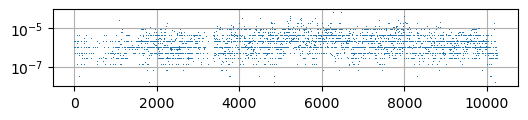

In [15]:
rbuf[:] = np.random.randn(*rbuf.shape)
t = 120
cr[:] = 0.0
numpy_delays(rbuf, nh_r, t, iL, W.indices, W.data, W.indptr, cr)

cr2 = np.zeros_like(cr)
lib.delays(512, nv, nh_r, t, cr2, rbuf, W.data, iL, W.indices, W.indptr)

figure(figsize=(6, 1)); semilogy(cr - cr2, ','); grid(1)

then embed it in a simulation

In [16]:
def dfun(t, drV, rbuf, rV, cr, k):
    lib.delays(512, nv, nh_r, t, cr, rbuf, W.data, iL, W.indices, W.indptr)
    Delta = 2.0
    tau = 1.0
    J = 15.0
    I = 1.0
    eta = -5.0
    r, V = rV
    drV[0] = Delta / (pi * tau) + 2*V*r
    drV[1] = V*V - pi*pi * tau*tau * r*r + eta + J * tau * r + I + k*cr
    return drV

V = np.zeros_like(rbuf[t]) - 2.0
drV = np.zeros((2,nv,num_sims), 'f')
dfun(t, drV, rbuf, np.array([rbuf[t], V]), cr, 1e-3).shape

(2, 10240, 1)

In [17]:
def rgt0(r):
    r[r<0] = 0

def step(t, d1, d2, rbuf, rV, cr, dt, *args):
    dfun(t, d1, rbuf, rV, cr, *args)
    rVi = rV + dt*d1
    rgt0(rVi[0])
    dfun(t, d2, rbuf, rVi, cr, *args)
    rV += dt/2*(d1 + d2)
    rgt0(rV[0])
    rbuf[t%nh_r] = rV[0]

In [18]:
d1, d2 = np.zeros((2, 2, nv, num_sims), 'f')
dt = 0.1
rV = np.array([rbuf[t], V])
step(3, d1, d2, rbuf, rV, cr, dt, 1e-4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 556.01it/s]


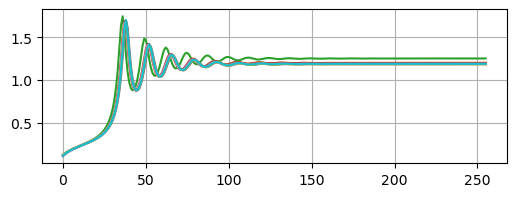

In [20]:
rs = []
rbuf = np.random.randn(nh_r, nv, num_sims).astype('f')/100 + 0.1
rV = np.zeros((2, nv, num_sims), 'f')
rV[0] = np.random.randn(nv, num_sims)/100 + 0.1
rV[1] -= 2.0
k = 1e-3
for i in tqdm.trange(256):
    step(i, d1, d2, rbuf, rV, cr, dt, k)
    rs.append(rV[0].copy())
rs = np.array(rs)[:,:,0]

figure(figsize=(6,2)); plot(rs[:, :10]); grid(1);

this stil has some overhead from numpy operations.  we can fold those into the kernel in a single loop over nodes for the Heun step because of the delays. 

we also create a custom struct to hold all the simulation configuration since the list of arguments to the kernels becomes error prone,

In [39]:
%%file delays3.ispc

struct sim {
    const int chunksize;
    const int nvtx;
    const int nh;
    int t;
    
    float *buf;
    float *V;
    const float *weights;
    const int *idelays;
    const int *indices;
    const int *indptr;
    
    const float dt;
    const float Delta;
    const float pi;
    const float tau;
    const float J;
    const float eta;
    const float I;
    const float k;
};


float get_aff_ij(const uniform struct sim &s, const uniform int t, const varying int j) {
    const varying int dij = (s.nh + t - s.idelays[j]) & (s.nh-1);
    return s.weights[j] * s.buf[dij*s.nvtx + s.indices[j]];
}

task void delays_task(const uniform int start, const uniform int chunksize,
                      const uniform struct sim &s)
{
    // loop over nodes
    for (uniform int i=start; i<(start + chunksize); i++)
    {
        // SIMD the sparse coupling terms
        // we can issue both at once due to delays
        varying float acc1 = 0;
        varying float acc2 = 0;
        foreach (j = s.indptr[i] ... s.indptr[i+1]) {
            acc1 += get_aff_ij(s, s.t, j);
            acc2 += get_aff_ij(s, s.t+1, j);
        }
        uniform float cr1 = reduce_add(acc1);
        uniform float cr2 = reduce_add(acc2);
        
        // rest is not SIMD but hardly matters for performance
        uniform float r = s.buf[((s.t) & (s.nh - 1))*s.nvtx + i];
        uniform float V = s.V[i];
        
        // Heun predictor
        uniform float dr1 = s.Delta / (s.pi * s.tau) + 2*V*r;
        uniform float dV1 = V*V - s.pi*s.pi * s.tau*s.tau * r*r + s.eta + s.J * s.tau * r + s.I + s.k*cr1;
        uniform float ri = r + s.dt*dr1;
        ri = ri>0 ? ri : 0;
        uniform float Vi = V + s.dt*dV1;
        
        // Heun corrector
        uniform float dr2 = s.Delta / (s.pi * s.tau) + 2*Vi*ri;
        uniform float dV2 = Vi*Vi - s.pi*s.pi * s.tau*s.tau * ri*ri + s.eta + s.J * s.tau * ri + s.I + s.k*cr2;
        uniform float nr = r + s.dt*0.5*(dr1 + dr2);
        uniform float nV = V + s.dt*0.5*(dV1 + dV2);
        nr = nr>0 ? nr : 0;
        
        // update buffer
        s.buf[((s.t + 1) & (s.nh - 1))*s.nvtx + i] = nr;
        s.V[i] = nV;
    }
}

// this function is called by Python and distributes vertices over CPUs
export void delays(uniform struct sim &s)
{
    uniform int chunks = s.nvtx / s.chunksize;
    for (uniform int start=0; start<chunks; start++)
        launch delays_task(start*s.chunksize, s.chunksize, s);
    launch delays_task(chunks*s.chunksize, s.nvtx-chunks*s.chunksize, s);
    sync;
}

Overwriting delays3.ispc


In [40]:
import os, ctypes as ct, numpy as np, hashlib

fvec = np.ctypeslib.ndpointer(dtype=np.float32)
ivec = np.ctypeslib.ndpointer(dtype=np.int32)

os.system('ispc -g delays3.ispc --pic -O3 -o delays3.ispc.o')

with open('delays3.ispc', 'rb') as fd:
    cc = hashlib.md5(fd.read()).hexdigest()[-4:]
os.system(f'g++ -shared tasksys.o delays3.ispc.o -o delays{cc}.ispc.so -lpthread')
lib2 = ct.CDLL(f'./delays{cc}.ispc.so')

# this is the equivalent of the struct in the C code above
class Sim(ct.Structure):
    _fields_ = [
        ('chunksize', ct.c_int), # const int 
        ('nvtx', ct.c_int), # const int 
        ('nh', ct.c_int), # const int 
        ('t', ct.c_int), # const int 
        ('buf', fvec), # float *
        ('V', fvec), # float *
        ('weights', fvec), # const float *
        ('idelays', ivec), # const int *
        ('indices', ivec), # const int *
        ('indptr', ivec), # const int *
        ('dt', ct.c_float), # const float 
        ('Delta', ct.c_float), # const float 
        ('pi', ct.c_float), # const float 
        ('tau', ct.c_float), # const float 
        ('J', ct.c_float), # const float 
        ('eta', ct.c_float), # const float 
        ('I', ct.c_float), # const float 
        ('k', ct.c_float), # const float 
    ]

        "avx2-i32x8". 
delays3.ispc:27:41: Performance Warning: Gather required to load value. 
    const varying int dij = (s.nh + t - s.idelays[j]) & (s.nh-1);
                                        ^^^^^^^^^^^^

delays3.ispc:28:12: Performance Warning: Gather required to load value. 
    return s.weights[j] * s.buf[dij*s.nvtx + s.indices[j]];
           ^^^^^^^^^^^^

delays3.ispc:28:46: Performance Warning: Gather required to load value. 
    return s.weights[j] * s.buf[dij*s.nvtx + s.indices[j]];
                                             ^^^^^^^^^^^^

delays3.ispc:28:27: Performance Warning: Gather required to load value. 
    return s.weights[j] * s.buf[dij*s.nvtx + s.indices[j]];
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



In [48]:
s = Sim()
s.chunksize = 64
s.nvtx = nvtx
s.nh = nh_r
s.t = 12  # dummy value, will be set in loop
s.buf = rbuf.ctypes.data
s.V = V.ctypes.data
s.weights = W.data.ctypes.data
s.idelays = iL.ctypes.data
s.indices = W.indices.ctypes.data
s.indptr = W.indptr.ctypes.data
s.dt = dt
s.Delta = 2.0
s.pi = np.pi
s.tau = 1.0
s.J = 15.0
s.eta = -5.0
s.I = 1.0
s.k = 1e-3

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:02<00:00, 1010.87it/s]


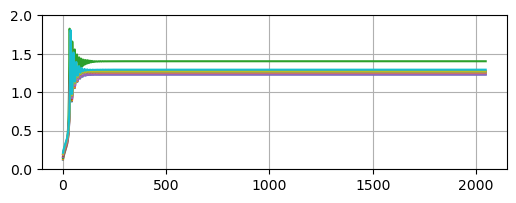

In [49]:
rs2 = []
np.random.seed(42)
rbuf = np.random.randn(nh_r, nv).astype('f')/100 + 0.1
rbuf[rbuf<0] = 0
V = np.random.randn(nv).astype('f')/100 - 2.0

s.buf = rbuf.ctypes.data
s.V = V.ctypes.data
s.k = 0.003
s.dt = 0.1
for i in tqdm.trange(2048):
    s.t = i
    lib2.delays(ct.byref(s))
    rs2.append( rbuf[(i+1)&(s.nh-1)].copy() )
rs2 = np.array(rs2)

figure(figsize=(6, 2)); plot(rs2[:, :10] + np.r_[:10]*0.01); ylim([0, 2]); grid(1)

This is only about 2x faster, after folding the neural mass equations and Heun step into the C code.  It's also significantly more complicated to write.

A few more experiments to consider

- reorder the buffer?
- run multiple simulations at once